In [46]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import os
import pathlib
import matplotlib.dates as md
import matplotlib.gridspec as gridspec

In [44]:
def rescale_plot(W=5, l=6, w=3):
    plt.rcParams.update({
            'figure.figsize': (W, W/(l/w)),     # 6:3 aspect ratio
            'font.size' : 10,                   # Set font size to 11pt
            'axes.labelsize': 10,               # -> axis labels
            'legend.fontsize': 10,              # -> legends
            'font.family': 'lmodern',
            'text.usetex': True,
            'text.latex.preamble': (            # LaTeX preamble
                r'\usepackage{lmodern}'
                # ... more packages if needed
            )
        })

In [30]:
data_path     = pathlib.Path(os.path.abspath(os.path.join('..')), "data")
reward_path   = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Rewards")
feature_path  = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Features")

In [368]:
asset_names    = ("BIDU", "COST", "CSCO", "GILD", "DELL", "GOOG", "INTC") 

In [225]:
asset_stats = {}
for asset_name in asset_names:
    all_data = None
    len_data = 0
    for filename in os.listdir(feature_path):
        f = os.path.join(feature_path, filename)
        # checking if it is a file
        if os.path.isfile(f):
            if asset_name in filename:
                trade_date = filename.split('_')[1]
                feature_fn = f'{asset_name}_{trade_date}_LOB_features.pkl'
                _all_data  = pd.read_pickle(f'{str(feature_path)}/{feature_fn}').set_index('timestamp')
                len_data   += len(_all_data)
                _all_data  = _all_data[~_all_data.index.duplicated()].resample('1s').last().fillna(method='ffill')
                if all_data is None:
                    all_data = _all_data
                else:
                    all_data = pd.concat((all_data, _all_data), axis=0)
    all_data = all_data.sort_index()
    print('*************************')
    print(asset_name)
    print('*************************')
    print('Lenght of data', len_data)
    print('Average B/A spread', all_data.ba_spread.mean())
    asset_stats[asset_name] =  all_data.describe()

*************************
BIDU
*************************
Lenght of data 12024734


0.08097596332500163

*************************
COST
*************************
Lenght of data 15943593


0.2673858835788763

*************************
CSCO
*************************
Lenght of data 33422600


0.01036896365047377

*************************
GILD
*************************
Lenght of data 18047686


0.016680224211913904

*************************
DELL
*************************
Lenght of data 12048334


0.017550312832269047

*************************
GOOG
*************************
Lenght of data 68398222


0.014795115911894882

*************************
INTC
*************************
Lenght of data 28088943


0.010071152030626121

In [226]:
all_data.describe()

,mid_price,imbalance_1,ba_spread,macd_120_260_90,macd_1200_2600_900,time_of_day,macd_12_26_9
count,923656.000000,923656.000000,923656.000000,923656.000000,923656.000000,923656.0,923656.000000
mean,27.841362,0.010538,0.010071,-0.006590,-0.000004,0.0,-0.000025
std,1.554437,0.404748,0.000849,1.920532,0.002246,0.0,0.193384
min,24.595000,-0.999892,0.010000,-27.035656,-0.024178,0.0,-7.930687
25%,26.515000,-0.248786,0.010000,-1.058741,-0.001411,0.0,-0.000052
50%,27.785000,0.016110,0.010000,0.001565,-0.000005,0.0,0.000000
75%,28.985000,0.277043,0.010000,1.050455,0.001409,0.0,0.000056
max,31.335000,0.999902,0.050000,24.873115,0.022470,0.0,6.992925


# Signals predictive power

In [227]:
def add_fwd_cols(all_fwd_cols, _LOB_features):
    for col in all_fwd_cols:
        fwd_w = int(col.split('_')[-1])
        _LOB_features[col] = _LOB_features['mid_price'].diff(int(fwd_w/10)).shift(-int(fwd_w/10))

In [228]:
tick_size     = 0.01

fwd_cols = []
fwd_col_l = (1, 5, 10, 20, 50, 40, 60, 100, 300, 500, 1000, 5000, 10000, 20000, 50000, 100000)
for w in fwd_col_l:
    fwd_cols += [f'fwd_price_move_{w}']

In [357]:
LOB_features.columns

Index(['mid_price', 'imbalance_1', 'ba_spread', 'macd_120_260_90',
       'macd_1200_2600_900', 'timestamp', 'time_of_day', 'macd_12_26_9',
       'fwd_price_move_1', 'fwd_price_move_5', 'fwd_price_move_10',
       'fwd_price_move_20', 'fwd_price_move_50', 'fwd_price_move_40',
       'fwd_price_move_60', 'fwd_price_move_100', 'fwd_price_move_300',
       'fwd_price_move_500', 'fwd_price_move_1000', 'fwd_price_move_5000',
       'fwd_price_move_10000', 'fwd_price_move_20000', 'fwd_price_move_50000',
       'fwd_price_move_100000'],
      dtype='object')

In [369]:
results = {}

for asset_name in asset_names:
    print('********************************')
    print('* ', asset_name)
    print('********************************')
    
    dic_results    = {}
    
    feature_1_name = 'macd_12_26_9'
    feature_2_name = 'imbalance_1'

    filenames      = os.listdir('../data/Features')
    trade_dates    = [fn.split('_')[1] for fn in filenames if asset_name in fn]
    
    for trade_date in trade_dates:
        #print('Reading:',trade_date)
        features_fn   = f'{asset_name}_{trade_date}_LOB_features.pkl'
        try:
            LOB_features = pd.read_pickle(f'../data/Features/{features_fn}')
        except Exception as e:
            print('error')
            LOB_data, LOB_messages     = get_LOB_data(f'{os.getcwd()}/../{data_path}', asset_name, trade_date)
            LOB_features  = get_LOB_features(LOB_data,
                                             trade_date = trade_date,
                                             LOB_msg    = LOB_messages)
            LOB_features.to_pickle(f'../data/Features/LOB_features_{trade_date}.pkl')
        
        LOB_features[feature_1_name] = LOB_features[feature_1_name].round(0)
        LOB_features[feature_2_name] = LOB_features[feature_2_name].round(1)
        
        add_fwd_cols(fwd_cols, LOB_features)

        LOB_features_predictive = LOB_features[[feature_1_name, feature_2_name] + fwd_cols].dropna()
        
        predictive_feature = feature_1_name
        counts1 = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).count())
        avgs1   = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).mean())
        avgs1[counts1<100]=np.nan
        avgs1 = avgs1.sort_index().fillna(method='ffill').fillna(method='bfill')

        predictive_feature = feature_2_name
        counts2 = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).count())
        avgs2   = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).mean())
        avgs2[counts2<100]=np.nan
        avgs2 = avgs2.sort_index().fillna(method='ffill').fillna(method='bfill')
    
        dic_results[trade_date] = (counts1, avgs1, counts2, avgs2)

        #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        #avgs1.plot(ax=ax1)
        #avgs2.plot(ax=ax2)
        #plt.show()
        
    results[asset_name] = dic_results

********************************
*  BIDU
********************************
********************************
*  COST
********************************
********************************
*  CSCO
********************************
********************************
*  GILD
********************************
********************************
*  DELL
********************************
********************************
*  GOOG
********************************
********************************
*  INTC
********************************


In [370]:
avg_results = {}
for asset_name in asset_names:
    # Plot for a given 
    avgs1 = pd.concat((pd.concat((results[asset_name][s][1][colname] 
                for s in results[asset_name].keys()), axis=1).dropna().mean(axis=1).rolling(2).mean() for colname in fwd_cols), axis=1)
    
    avgs2 = pd.concat((pd.concat((results[asset_name][s][3][colname] 
                for s in results[asset_name].keys()), axis=1).dropna().mean(axis=1).rolling(2).mean() for colname in fwd_cols), axis=1)
    
    avg_results[asset_name] = (avgs1, avgs2)

forward column 50


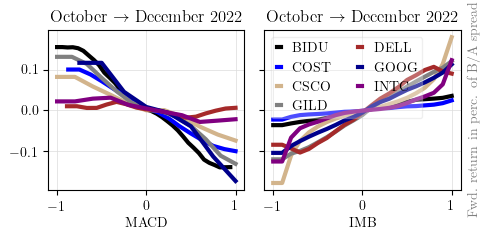

In [371]:
asset_name = asset_names[0]
fwd_col_l_ = 4 #7
print('forward column', fwd_col_l[fwd_col_l_])

rescale_plot(W=5, l=6, w=3)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)

l_colors       = ("k", "blue", "tan", "grey", "brown", "darkblue", "purple")
asset_names    = ("BIDU", "COST", "CSCO", "GILD", "DELL", "GOOG", "INTC") 


#trend
for (asset_name, l_color) in zip(asset_names, l_colors):
    avgs1, avgs2 = avg_results[asset_name]

    # rescale MACD to make it comparable
    avgs1.index = avgs1.index/np.max(np.abs(np.array(avgs1.index)))    

    ax1.plot(avgs1.iloc[:,fwd_col_l_].fillna(method='bfill')/asset_stats[asset_name].ba_spread['mean'], color=l_color, lw=3)
    ax2.plot(avgs2.iloc[:,fwd_col_l_].fillna(method='bfill')/asset_stats[asset_name].ba_spread['mean'], color=l_color, lw=3)

for ax in (ax1,ax2):
#ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set_color('grey')
    ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
ax2.legend(asset_names, loc='upper left', fancybox=True, framealpha=0.3, handlelength=0.3, ncol=2)
#ax1.legend(asset_names, loc='upper right', fancybox=True, framealpha=0.5, handlelength=0.2)

#ax1.set_xlim(-5, 5)
#ax1.set_ylim(-0.5, 0.5)
ax2.set_ylabel('Fwd. return in perc. of B/A spread')
ax1.set_xlabel('MACD')
ax2.set_xlabel('IMB')

ax1.set_title(r'October $\rightarrow$ December 2022')
ax2.set_title(r'October $\rightarrow$ December 2022')

plt.tight_layout()
plt.savefig(f'plots/AOE0.pdf', bbox_inches='tight')

# Evidence of non stationarity

In [400]:
asset_name     = 'DELL' #asset_names[0]
filenames      = os.listdir('../data/Features')
trade_dates    = [fn.split('_')[1] for fn in filenames if asset_name in fn]

dic_results    = {}

feature_1_name = 'macd_12_26_9' #macd_12_26_9

In [401]:
LOB_features.columns

Index(['mid_price', 'imbalance_1', 'ba_spread', 'macd_120_260_90',
       'macd_1200_2600_900', 'timestamp', 'time_of_day', 'macd_12_26_9',
       'fwd_price_move_1', 'fwd_price_move_5', 'fwd_price_move_10',
       'fwd_price_move_20', 'fwd_price_move_50', 'fwd_price_move_40',
       'fwd_price_move_60', 'fwd_price_move_100', 'fwd_price_move_300',
       'fwd_price_move_500', 'fwd_price_move_1000', 'fwd_price_move_5000',
       'fwd_price_move_10000', 'fwd_price_move_20000', 'fwd_price_move_50000',
       'fwd_price_move_100000'],
      dtype='object')

In [407]:
for trade_date in trade_dates:
#print('Reading:',trade_date)
    features_fn   = f'{asset_name}_{trade_date}_LOB_features.pkl'
    try:
        LOB_features = pd.read_pickle(f'../data/Features/{features_fn}')
    except Exception as e:
        print('error')
        LOB_data, LOB_messages     = get_LOB_data(f'{os.getcwd()}/../{data_path}', asset_name, trade_date)
        LOB_features  = get_LOB_features(LOB_data,
                                         trade_date = trade_date,
                                         LOB_msg    = LOB_messages)
        LOB_features.to_pickle(f'../data/Features/LOB_features_{trade_date}.pkl')

    LOB_features[feature_1_name] = LOB_features[feature_1_name].round(0)

    add_fwd_cols(fwd_cols, LOB_features)

    LOB_features_predictive = LOB_features[[feature_1_name] + fwd_cols].dropna()

    predictive_feature = feature_1_name
    counts1 = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).count())
    avgs1   = (LOB_features_predictive[[predictive_feature] + fwd_cols].groupby(predictive_feature).mean())
    avgs1[counts1<10]=np.nan
    avgs1 = avgs1.sort_index()#.fillna(method='ffill').fillna(method='bfill')
    
    dic_results[trade_date] = (counts1, avgs1)
    
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    #avgs1.plot(ax=ax1)
    #avgs2.plot(ax=ax2)
    #plt.show()
print('DONE')

DONE


In [408]:
counts1, avgs1 = dic_results[trade_date]
avgs1_ = avgs1.iloc[:,fwd_col_l_].dropna()
#avgs1_

In [409]:
#avgs1.iloc[:,fwd_col_l_]

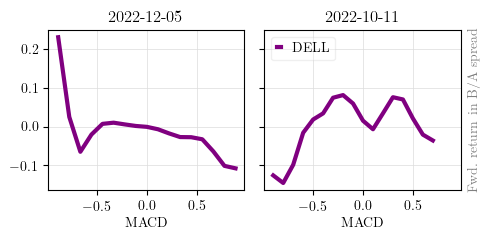

In [410]:
trade_date_1 = trade_dates[0]
trade_date_2 = '2022-10-11' #trade_dates[2]
#14nov, 11oct, 5OCt, 
fwd_col_l_    = 4 #7
rescale_plot(W=5, l=6, w=3)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True) 

for (trade_date, ax) in zip((trade_date_1, trade_date_2), (ax1, ax2)):
    counts1, avgs1 = dic_results[trade_date]
    avgs1_ = avgs1.iloc[:,fwd_col_l_].dropna()
    avgs1_.index = avgs1_.index/np.max(np.abs(np.array(avgs1_.index)))    
    avgs1_ = avgs1_.rolling(2).mean()[::-1].rolling(2).mean()[::-1]
    ax.plot(avgs1_/asset_stats[asset_name].ba_spread['mean'], color=l_color, lw=3)

for ax in (ax1,ax2): ax.yaxis.set_label_position("right"); ax.yaxis.label.set_color('grey'); ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5); ax.set_axisbelow(True)

ax2.legend([asset_name], loc='upper left', fancybox=True, framealpha=0.3, handlelength=0.3, ncol=2)

#ax1.set_xlim(-5, 5)
#ax1.set_ylim(-0.5, 0.5)
ax2.set_ylabel('Fwd. return in B/A spread')
ax1.set_xlabel('MACD'); ax2.set_xlabel('MACD')
ax1.set_title(trade_date_1); ax2.set_title(trade_date_2)

plt.tight_layout()
plt.savefig(f'plots/NS_{asset_name}.pdf', bbox_inches='tight')

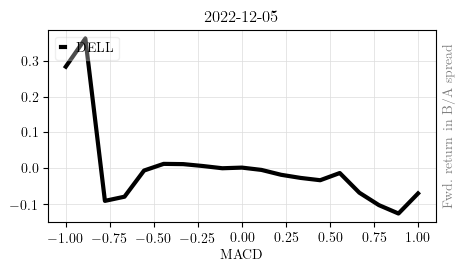

<Figure size 500x250 with 0 Axes>

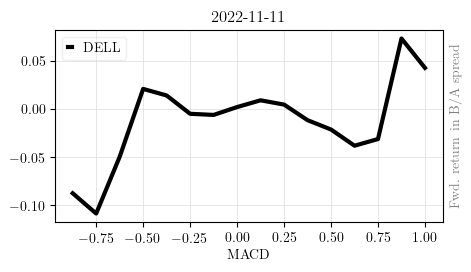

<Figure size 500x250 with 0 Axes>

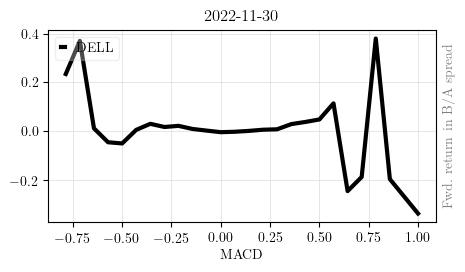

<Figure size 500x250 with 0 Axes>

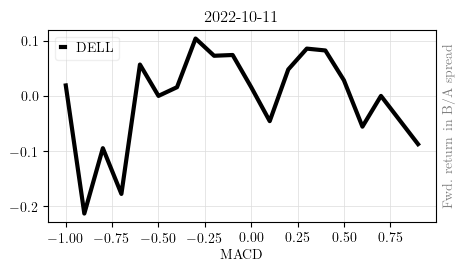

<Figure size 500x250 with 0 Axes>

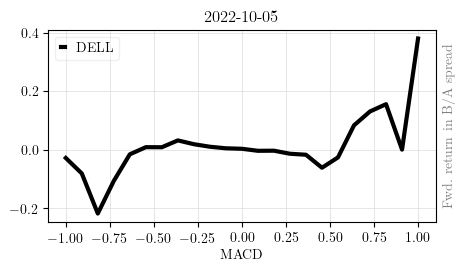

<Figure size 500x250 with 0 Axes>

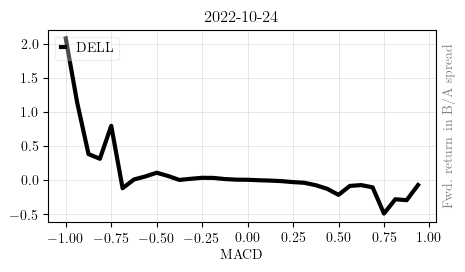

<Figure size 500x250 with 0 Axes>

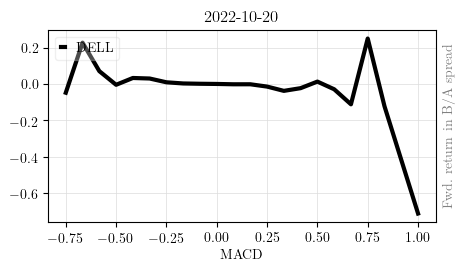

<Figure size 500x250 with 0 Axes>

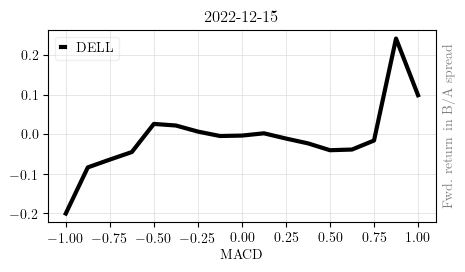

<Figure size 500x250 with 0 Axes>

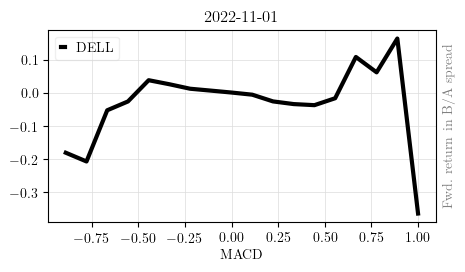

<Figure size 500x250 with 0 Axes>

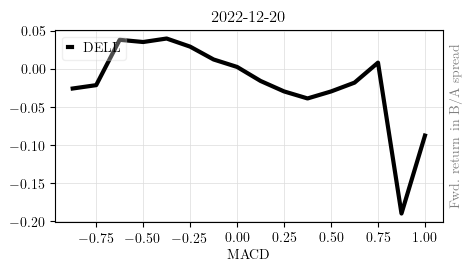

<Figure size 500x250 with 0 Axes>

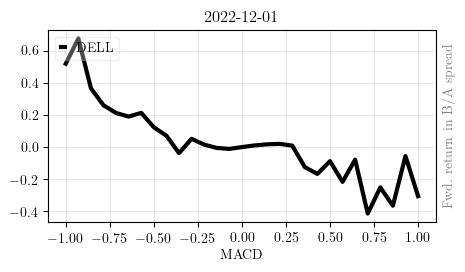

<Figure size 500x250 with 0 Axes>

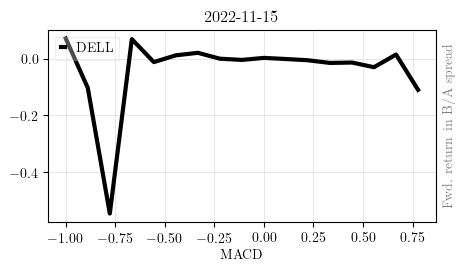

<Figure size 500x250 with 0 Axes>

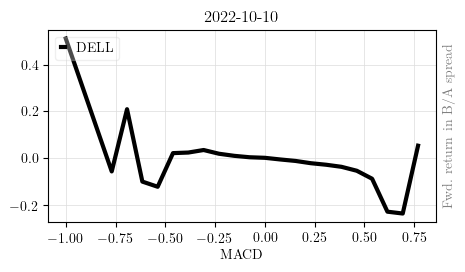

<Figure size 500x250 with 0 Axes>

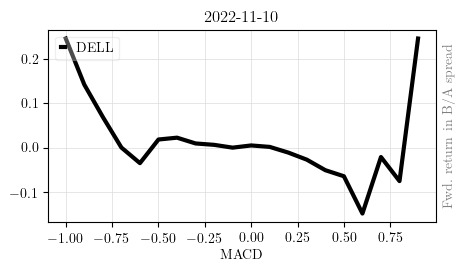

<Figure size 500x250 with 0 Axes>

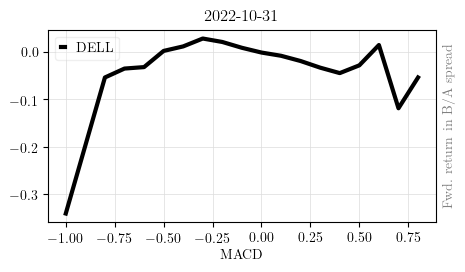

<Figure size 500x250 with 0 Axes>

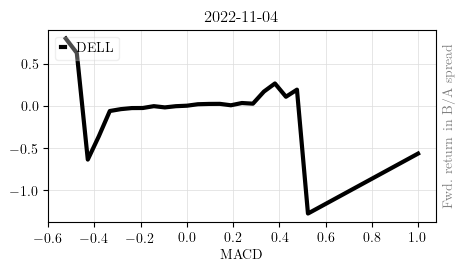

<Figure size 500x250 with 0 Axes>

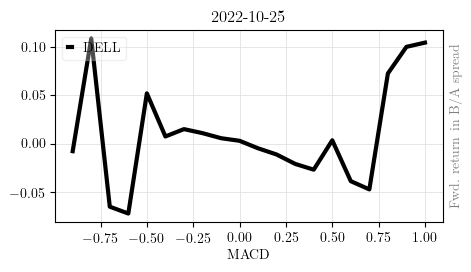

<Figure size 500x250 with 0 Axes>

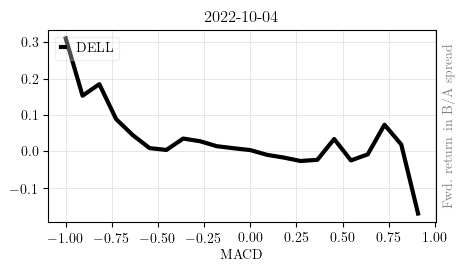

<Figure size 500x250 with 0 Axes>

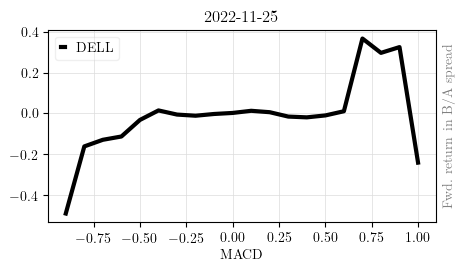

<Figure size 500x250 with 0 Axes>

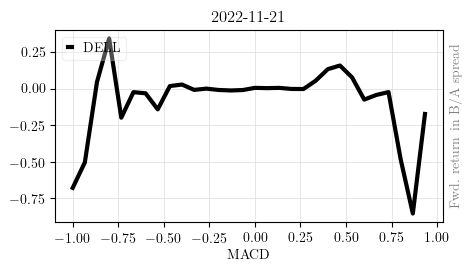

<Figure size 500x250 with 0 Axes>

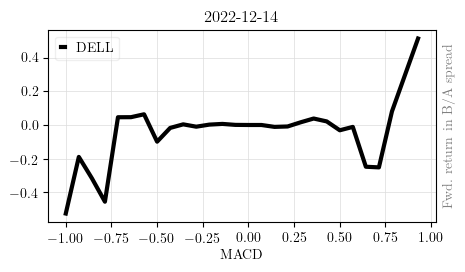

<Figure size 500x250 with 0 Axes>

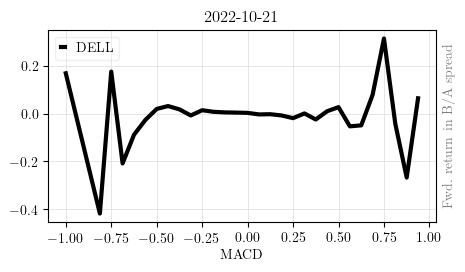

<Figure size 500x250 with 0 Axes>

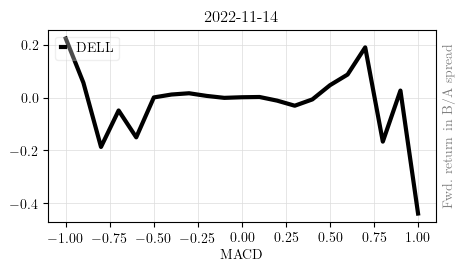

<Figure size 500x250 with 0 Axes>

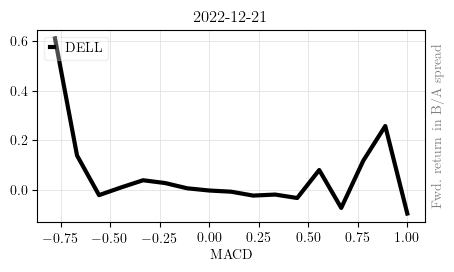

<Figure size 500x250 with 0 Axes>

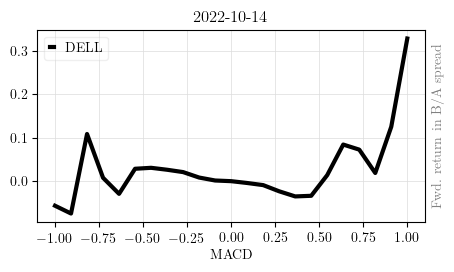

<Figure size 500x250 with 0 Axes>

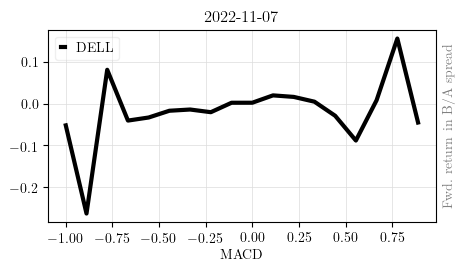

<Figure size 500x250 with 0 Axes>

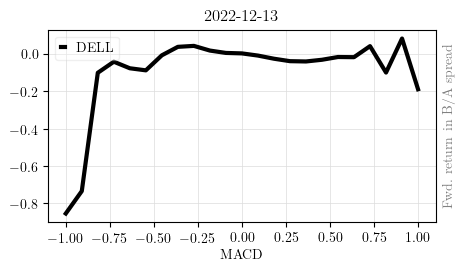

<Figure size 500x250 with 0 Axes>

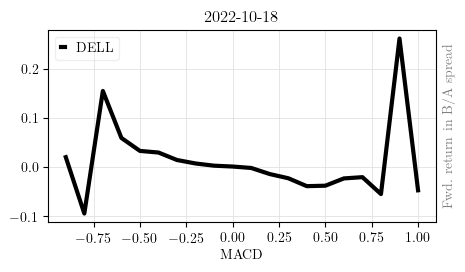

<Figure size 500x250 with 0 Axes>

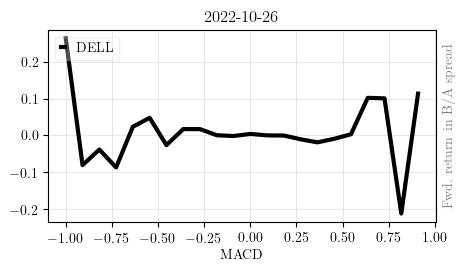

<Figure size 500x250 with 0 Axes>

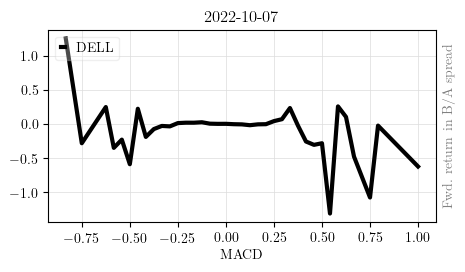

<Figure size 500x250 with 0 Axes>

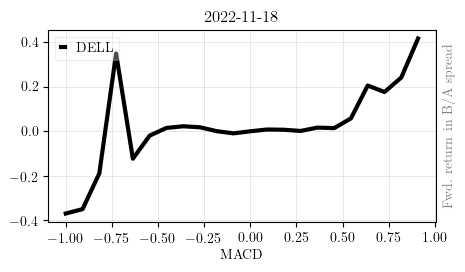

<Figure size 500x250 with 0 Axes>

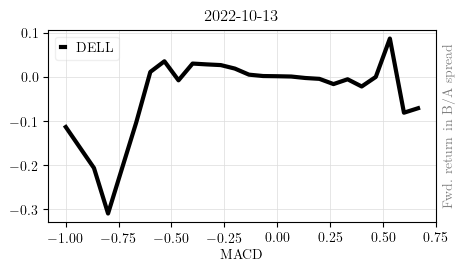

<Figure size 500x250 with 0 Axes>

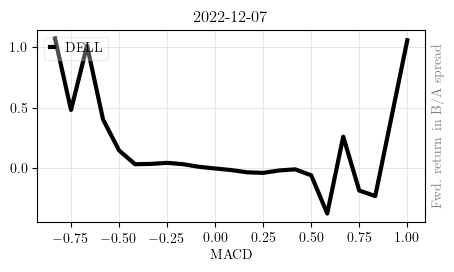

<Figure size 500x250 with 0 Axes>

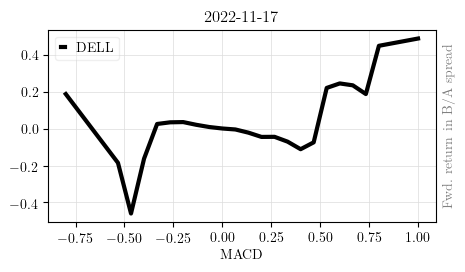

<Figure size 500x250 with 0 Axes>

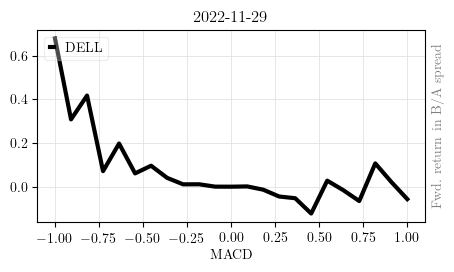

<Figure size 500x250 with 0 Axes>

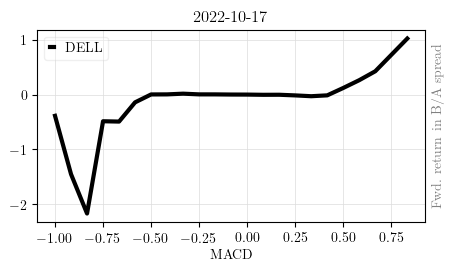

<Figure size 500x250 with 0 Axes>

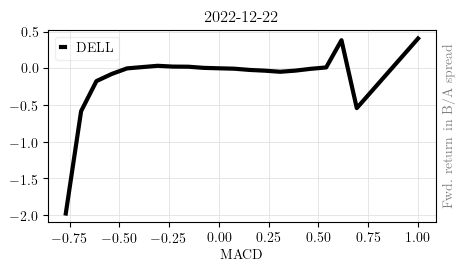

<Figure size 500x250 with 0 Axes>

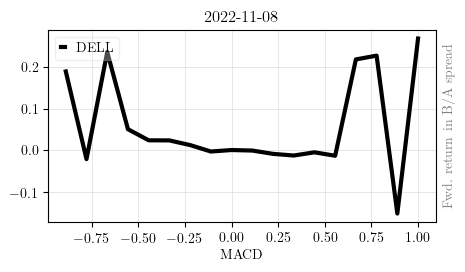

<Figure size 500x250 with 0 Axes>

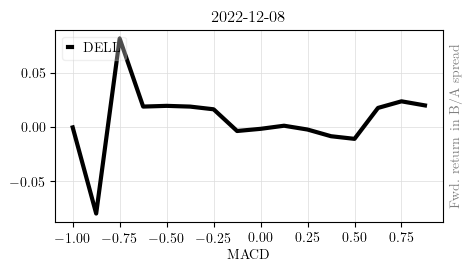

<Figure size 500x250 with 0 Axes>

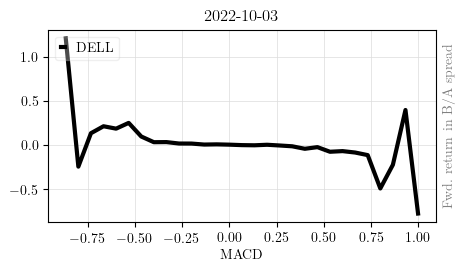

<Figure size 500x250 with 0 Axes>

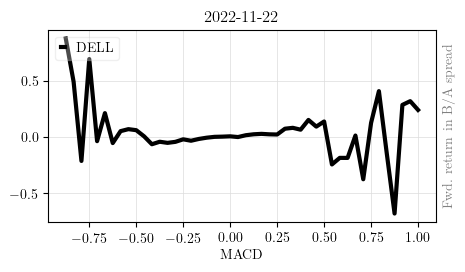

<Figure size 500x250 with 0 Axes>

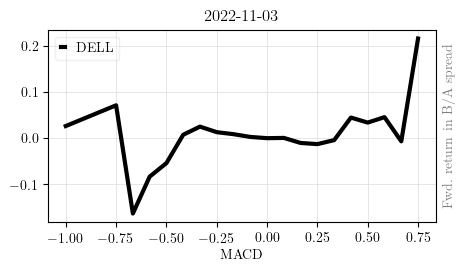

<Figure size 500x250 with 0 Axes>

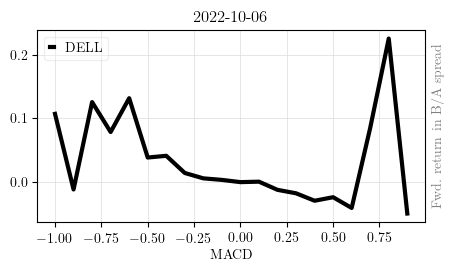

<Figure size 500x250 with 0 Axes>

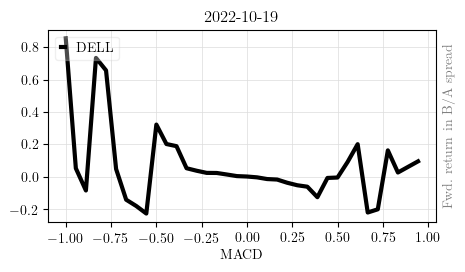

<Figure size 500x250 with 0 Axes>

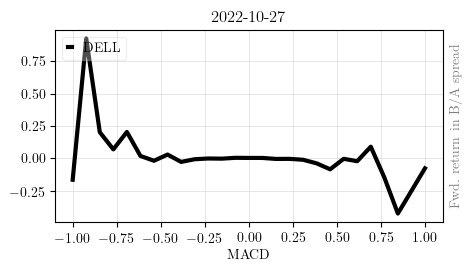

<Figure size 500x250 with 0 Axes>

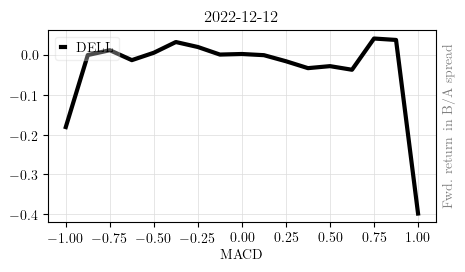

<Figure size 500x250 with 0 Axes>

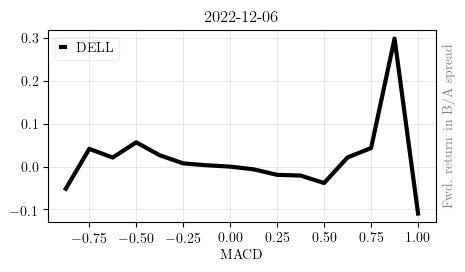

<Figure size 500x250 with 0 Axes>

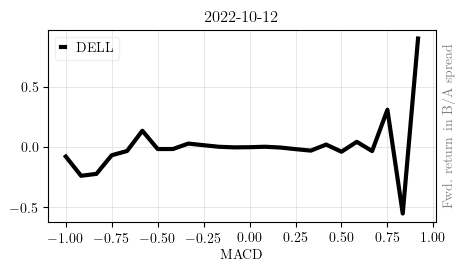

<Figure size 500x250 with 0 Axes>

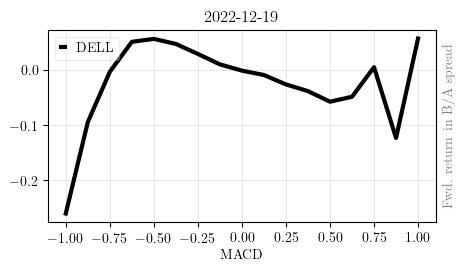

<Figure size 500x250 with 0 Axes>

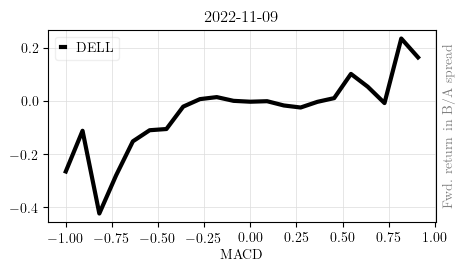

<Figure size 500x250 with 0 Axes>

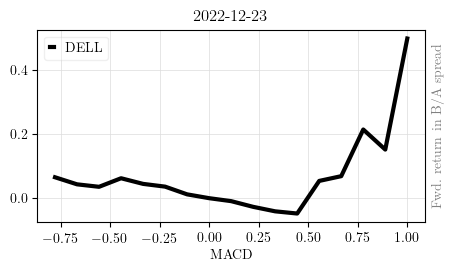

<Figure size 500x250 with 0 Axes>

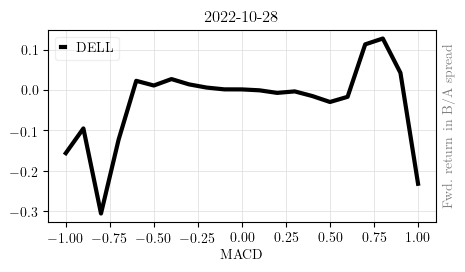

<Figure size 500x250 with 0 Axes>

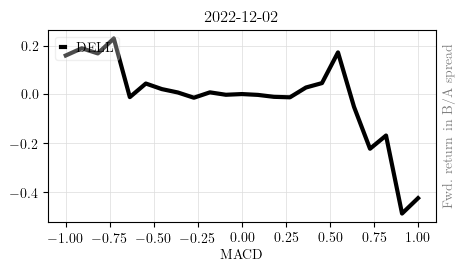

<Figure size 500x250 with 0 Axes>

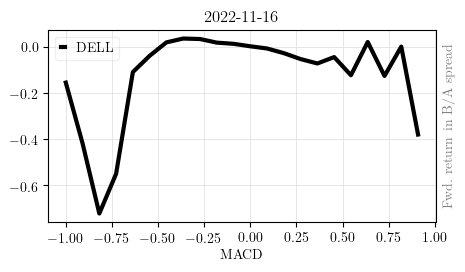

<Figure size 500x250 with 0 Axes>

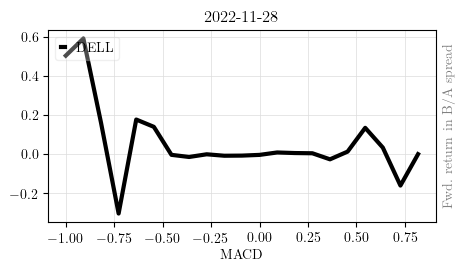

<Figure size 500x250 with 0 Axes>

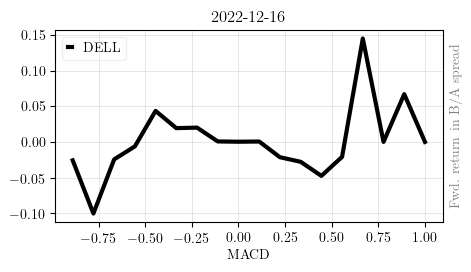

<Figure size 500x250 with 0 Axes>

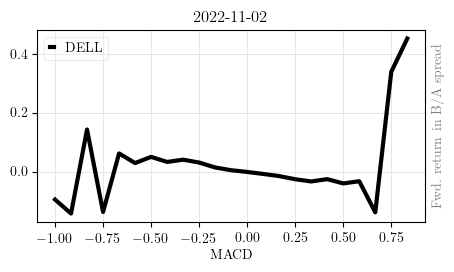

<Figure size 500x250 with 0 Axes>

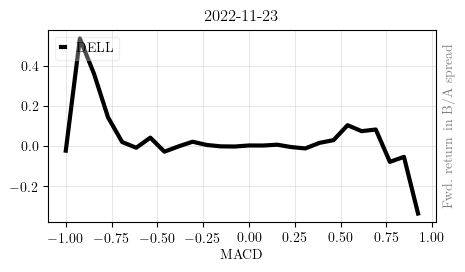

<Figure size 500x250 with 0 Axes>

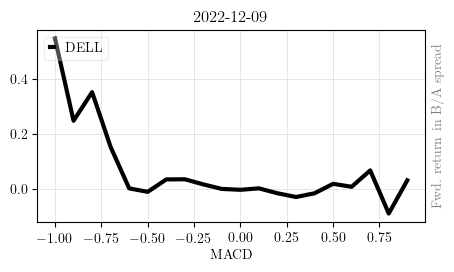

<Figure size 500x250 with 0 Axes>

In [411]:
for trade_date in trade_dates:
    fwd_col_l_ = 4 #7

    rescale_plot(W=5, l=6, w=3)

    fig, ax = plt.subplots(1, 1, sharey=True, sharex=True)

    counts1, avgs1 = dic_results[trade_date]
    avgs1_ = avgs1.iloc[:,fwd_col_l_].dropna()
    avgs1_.index = avgs1_.index/np.max(np.abs(np.array(avgs1_.index)))    
    #avgs1_ = avgs1_.rolling(4).mean()
    ax.plot(avgs1_/asset_stats[asset_name].ba_spread['mean'], color='k', lw=3)

    ax.yaxis.set_label_position("right"); ax.yaxis.label.set_color('grey'); ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5); ax.set_axisbelow(True)
    ax.legend([asset_name], loc='upper left', fancybox=True, framealpha=0.3, handlelength=0.3, ncol=2)
    
    #ax1.set_xlim(-5, 5)
    #ax1.set_ylim(-0.5, 0.5)
    ax.set_ylabel('Fwd. return in B/A spread')
    ax.set_xlabel('MACD'); ax2.set_xlabel('MACD')
    ax.set_title(trade_date)
    plt.show()
    plt.tight_layout()